In [1]:
import torch
from torch import nn
from torchvision import transforms, models, datasets
from PIL import Image
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
training_set_dir = "/Learn_pytorch/Computer_Vision_with_PyTorch/Cat_and_dog/training_set/training_set"
test_set_dir = "/Learn_pytorch/Computer_Vision_with_PyTorch/Cat_and_dog/test_set/test_set"

In [4]:
import random
import cv2
import os

In [5]:
class Cat_Dog(Dataset):
    def __init__(self,
                 folder: str):
        cats = glob(pathname=folder + "/cats/*.jpg")
        dogs = glob(pathname=folder + "/dogs/*.jpg")
        self.fpaths = cats + dogs
        random.shuffle(x=self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith("dog") for fpath in self.fpaths] # dog = 1, cat = 0
        
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, index):
        f = self.fpaths[index]
        target = self.targets[index]
        im = cv2.imread(f)[:, :, ::-1]
        im = cv2.resize(src=im, dsize=(224, 224))
        return torch.tensor(im/225).permute(2, 0, 1).to(device=device).float(), torch.tensor([target]).float().to(device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])

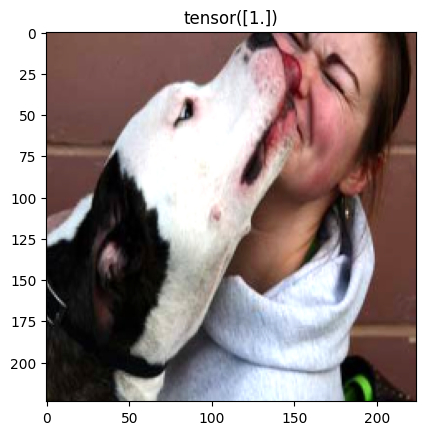

In [6]:
data = Cat_Dog(folder=training_set_dir)
img, label = random.choice(data)
plt.imshow(img.permute(1, 2, 0))
plt.title(label)
img.shape

In [7]:
def conv_layer(input_shape: int,
               output_shape: int,
               kernel_size: int,
               stride: int = 1):
    return nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=output_shape,
                  kernel_size=kernel_size,
                  stride=stride),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=output_shape),
        nn.MaxPool2d(kernel_size=2)
    )

In [8]:
class CNN_model(nn.Module):
    def __init__(self,
                 input_shape: int,
                 output_shape: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            conv_layer(input_shape=input_shape, output_shape=64, kernel_size=3),
            conv_layer(input_shape=64, output_shape=512, kernel_size=3),
            conv_layer(input_shape=512, output_shape=512, kernel_size=3),
            conv_layer(input_shape=512, output_shape=512, kernel_size=3),
            conv_layer(input_shape=512, output_shape=512, kernel_size=3),
            conv_layer(input_shape=512, output_shape=512, kernel_size=3)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512*1*1,
                      out_features=output_shape),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.classifier(self.conv_block(x))

In [9]:
# model = CNN_model(input_shape=3,
#                   output_shape=1)
model = torch.load(f="Cat_and_dog/models/model.pth")

In [10]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [11]:
from torchsummary import summary
summary(model=model, input_data=(3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Sequential: 2-1                   [-1, 64, 111, 111]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 222, 222]        1,792
|    |    └─ReLU: 3-2                    [-1, 64, 222, 222]        --
|    |    └─BatchNorm2d: 3-3             [-1, 64, 222, 222]        128
|    |    └─MaxPool2d: 3-4               [-1, 64, 111, 111]        --
|    └─Sequential: 2-2                   [-1, 512, 54, 54]         --
|    |    └─Conv2d: 3-5                  [-1, 512, 109, 109]       295,424
|    |    └─ReLU: 3-6                    [-1, 512, 109, 109]       --
|    |    └─BatchNorm2d: 3-7             [-1, 512, 109, 109]       1,024
|    |    └─MaxPool2d: 3-8               [-1, 512, 54, 54]         --
|    └─Sequential: 2-3                   [-1, 512, 26, 26]         --
|    |    └─Conv2d: 3-9                  [-1, 512, 52, 52]         2,359,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Sequential: 2-1                   [-1, 64, 111, 111]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 222, 222]        1,792
|    |    └─ReLU: 3-2                    [-1, 64, 222, 222]        --
|    |    └─BatchNorm2d: 3-3             [-1, 64, 222, 222]        128
|    |    └─MaxPool2d: 3-4               [-1, 64, 111, 111]        --
|    └─Sequential: 2-2                   [-1, 512, 54, 54]         --
|    |    └─Conv2d: 3-5                  [-1, 512, 109, 109]       295,424
|    |    └─ReLU: 3-6                    [-1, 512, 109, 109]       --
|    |    └─BatchNorm2d: 3-7             [-1, 512, 109, 109]       1,024
|    |    └─MaxPool2d: 3-8               [-1, 512, 54, 54]         --
|    └─Sequential: 2-3                   [-1, 512, 26, 26]         --
|    |    └─Conv2d: 3-9                  [-1, 512, 52, 52]         2,359,

In [12]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    return (correct/len(y_pred))*100

In [13]:
if torch.cuda.is_available():
    model.cuda()

In [14]:
from tqdm.auto import tqdm

c:\Users\HoangLee\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
def train_step(train_dataloader: DataLoader,
               model: nn.Module,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = "cpu"):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(tqdm(train_dataloader)):
        X, y = X.to(device), y.to(device)
        model.train()
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        acc = accuracy_fn(y_pred=torch.round(y_hat), y_true=y)
        train_loss += loss
        train_acc += acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.eval()
    
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"Train loss: {train_loss}        |       Train acc: {train_acc}")

In [18]:
def test_step(test_dataloader: DataLoader,
              model: nn.Module,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device = "cpu"):
    model.eval()
    with torch.inference_mode():
        test_loss, test_acc = 0, 0
        for batch, (X, y) in enumerate(tqdm(test_dataloader)):
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            test_loss += loss
            acc = accuracy_fn(y_pred=torch.round(y_hat), y_true=y)
            test_acc += acc
            for i in range(len(y)):
                print(f"Prediction: {torch.round(y_hat[i])}      |       Truth value: {y[i]}")
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        print(f"Test loss: {test_loss}      |       Test acc: {test_acc}")

In [16]:
train = Cat_Dog(training_set_dir)
train_dataloader = DataLoader(dataset=train, batch_size=32, shuffle=True, drop_last=True)
test = Cat_Dog(test_set_dir)
test_dataloader = DataLoader(dataset=test, batch_size=32, shuffle=True, drop_last=True)

In [18]:
from tqdm.auto import tqdm

In [19]:
epochs = 2
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}")
    train_step(train_dataloader=train_dataloader,
               model=model,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)

Epoch: 1


100%|██████████| 250/250 [46:31<00:00, 11.17s/it]


Train loss: 0.3370997905731201        |       Train acc: 84.975
Epoch: 2


100%|██████████| 250/250 [41:18<00:00,  9.92s/it]

Train loss: 0.23111943900585175        |       Train acc: 90.1375


In [20]:
torch.save(obj=model, f="Cat_and_dog/models/model.pth")

In [20]:
test_step(test_dataloader=test_dataloader,
          model=model,
          loss_fn=loss_fn,
          accuracy_fn=accuracy_fn,
          device=device)

  2%|▏         | 1/63 [00:05<05:19,  5.16s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Tr

  3%|▎         | 2/63 [00:09<04:52,  4.79s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Tr

  5%|▍         | 3/63 [00:14<04:40,  4.67s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Tr

  6%|▋         | 4/63 [00:18<04:28,  4.55s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Tr

  8%|▊         | 5/63 [00:23<04:23,  4.53s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Tr

 10%|▉         | 6/63 [00:27<04:17,  4.52s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Tr

 11%|█         | 7/63 [00:32<04:13,  4.52s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Tr

 13%|█▎        | 8/63 [00:36<04:07,  4.51s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Tr

 14%|█▍        | 9/63 [00:41<04:02,  4.49s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Tr

 16%|█▌        | 10/63 [00:45<03:58,  4.50s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Tr

 17%|█▋        | 11/63 [00:49<03:52,  4.48s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Tr

 19%|█▉        | 12/63 [00:54<03:48,  4.49s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Tr

 21%|██        | 13/63 [00:58<03:43,  4.47s/it]

Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Tr

 22%|██▏       | 14/63 [01:03<03:39,  4.47s/it]

Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Tr

 24%|██▍       | 15/63 [01:07<03:33,  4.45s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Tr

 25%|██▌       | 16/63 [01:12<03:28,  4.43s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Tr

 27%|██▋       | 17/63 [01:16<03:24,  4.44s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Tr

 29%|██▊       | 18/63 [01:21<03:20,  4.46s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Tr

 30%|███       | 19/63 [01:25<03:15,  4.45s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Tr

 32%|███▏      | 20/63 [01:30<03:12,  4.47s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Tr

 33%|███▎      | 21/63 [01:34<03:08,  4.49s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Tr

 35%|███▍      | 22/63 [01:39<03:04,  4.51s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Tr

 37%|███▋      | 23/63 [01:43<03:00,  4.50s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Tr

 38%|███▊      | 24/63 [01:48<02:57,  4.54s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Tr

 40%|███▉      | 25/63 [01:52<02:52,  4.54s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Tr

 41%|████▏     | 26/63 [01:57<02:47,  4.51s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Tr

 43%|████▎     | 27/63 [02:01<02:42,  4.51s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Tr

 44%|████▍     | 28/63 [02:06<02:37,  4.50s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Tr

 46%|████▌     | 29/63 [02:10<02:32,  4.49s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Tr

 48%|████▊     | 30/63 [02:15<02:29,  4.52s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Tr

 49%|████▉     | 31/63 [02:19<02:24,  4.51s/it]

Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Tr

 51%|█████     | 32/63 [02:24<02:20,  4.52s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Tr

 52%|█████▏    | 33/63 [02:28<02:14,  4.50s/it]

Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Tr

 54%|█████▍    | 34/63 [02:33<02:10,  4.51s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Tr

 56%|█████▌    | 35/63 [02:37<02:05,  4.48s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Tr

 57%|█████▋    | 36/63 [02:42<02:01,  4.48s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Tr

 59%|█████▊    | 37/63 [02:46<01:56,  4.50s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Tr

 60%|██████    | 38/63 [02:51<01:52,  4.50s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Tr

 62%|██████▏   | 39/63 [02:55<01:47,  4.50s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Tr

 63%|██████▎   | 40/63 [03:00<01:43,  4.50s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Tr

 65%|██████▌   | 41/63 [03:04<01:39,  4.50s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Tr

 67%|██████▋   | 42/63 [03:09<01:34,  4.52s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Tr

 68%|██████▊   | 43/63 [03:13<01:30,  4.51s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Tr

 70%|██████▉   | 44/63 [03:18<01:25,  4.53s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Tr

 71%|███████▏  | 45/63 [03:22<01:21,  4.52s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Tr

 73%|███████▎  | 46/63 [03:27<01:16,  4.53s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Tr

 75%|███████▍  | 47/63 [03:31<01:11,  4.49s/it]

Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Tr

 76%|███████▌  | 48/63 [03:36<01:07,  4.49s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Tr

 78%|███████▊  | 49/63 [03:40<01:02,  4.47s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Tr

 79%|███████▉  | 50/63 [03:45<00:58,  4.47s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Tr

 81%|████████  | 51/63 [03:49<00:53,  4.46s/it]

Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Tr

 83%|████████▎ | 52/63 [03:54<00:49,  4.46s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Tr

 84%|████████▍ | 53/63 [03:58<00:44,  4.46s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Tr

 86%|████████▌ | 54/63 [04:03<00:39,  4.44s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Tr

 87%|████████▋ | 55/63 [04:07<00:35,  4.47s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Tr

 89%|████████▉ | 56/63 [04:11<00:31,  4.46s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Tr

 90%|█████████ | 57/63 [04:16<00:26,  4.48s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Tr

 92%|█████████▏| 58/63 [04:20<00:22,  4.46s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Tr

 94%|█████████▎| 59/63 [04:25<00:17,  4.48s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Tr

 95%|█████████▌| 60/63 [04:29<00:13,  4.46s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Tr

 97%|█████████▋| 61/63 [04:34<00:08,  4.46s/it]

Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Tr

 98%|█████████▊| 62/63 [04:38<00:04,  4.46s/it]

Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Tr

100%|██████████| 63/63 [04:43<00:00,  4.50s/it]

Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Truth value: tensor([1.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([0.])      |       Truth value: tensor([0.])
Prediction: tensor([1.])      |       Tr